# **Product Recommendation at Bigbasket**

## **Part 1: Load Data**

In [1]:
# !pip install mlxtend

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.metrics.pairwise import cosine_similarity
from itertools import islice
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_excel("BigBasket.xls", sheet_name='POS DATA')

In [4]:
data.head()

,Member,Order,SKU,Created On,Description
0,M09736,6468572,34993740,22-09-2014 22:45,Other Sauces
1,M09736,6468572,15669800,22-09-2014 22:45,Cashews
2,M09736,6468572,34989501,22-09-2014 22:45,Other Dals
3,M09736,6468572,7572303,22-09-2014 22:45,Namkeen
4,M09736,6468572,15669856,22-09-2014 22:45,Sugar


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62141 entries, 0 to 62140
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Member       62141 non-null  object
 1   Order        62141 non-null  int64 
 2   SKU          62141 non-null  int64 
 3   Created On   62141 non-null  object
 4   Description  62141 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.4+ MB


In [6]:
# Convert Create On to datetime variable
data['Created On'] = pd.to_datetime(data['Created On'])

In [7]:
data.duplicated().sum()

np.int64(0)

The dataset consists of 62,141 rows and 5 variables. It is fully clean, with no missing values or duplicate records.

The 5 variables are:
- Member: Member ID
- Order: Order ID
- SKU: Identifying each product uniquely
- Created On: Time stamp, when the order was placed
- Description: Description of product

## **Part 2: Exploratory Data Analysis**


### **Dataset Overview**

In [8]:
for col in ['Member', 'Order', 'SKU', 'Description']:
    print(f'{col} has {data[col].nunique()} unique values.')
print(f"Created On ranges from {data['Created On'].min()} to {data['Created On'].max()}")

Member has 106 unique values.
Order has 8387 unique values.
SKU has 1732 unique values.
Description has 216 unique values.
Created On ranges from 2011-03-12 10:18:00 to 2014-12-09 21:35:00


### **Total number of orders placed by each member**

In [ ]:
orders_by_member = data.groupby('Member').agg(orders_placed=('Order', 'nunique'))
orders_by_member.sort_values(by='orders_placed').head()

,orders_placed
Member,
M33745,24
M59232,25
M50420,29
M51043,32
M56516,35


In [ ]:
pd.DataFrame(orders_by_member['orders_placed'].describe())

,orders_placed
count,106.000000
mean,79.122642
std,32.254554
min,24.000000
25%,55.250000
50%,75.000000
75%,93.500000
max,203.000000


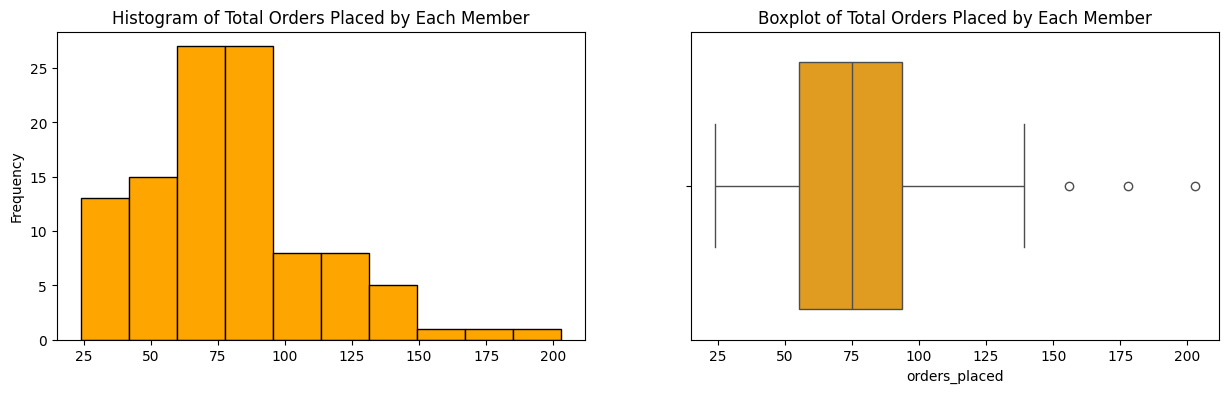

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

axes[0].hist(orders_by_member['orders_placed'], color='orange', edgecolor='black')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Total Orders Placed by Each Member')

sns.boxplot(x=orders_by_member['orders_placed'], ax=axes[1], color='orange')
axes[1].set_title('Boxplot of Total Orders Placed by Each Member')

plt.show()

**Insights:**

- The 106 members placed between 24 and 203 orders on BigBasket.
- 50% of the members placed at least 75 orders, indicating a strong engagement level.
- The dataset provides a comprehensive foundation for analyzing each member's shopping habits and purchasing patterns.

### **How long has each member used BigBasket?**

In [ ]:
# Calculate the difference between max and min order time for each member
order_duration = data.groupby('Member')['Created On'].agg(lambda x: (x.max() - x.min()).days)

order_duration = order_duration.reset_index().rename(columns={'Created On': 'Total Number of Days'})
order_duration.head()

,Member,Total Number of Days
0,M04158,965
1,M08075,717
2,M09303,697
3,M09736,510
4,M12050,622


In [ ]:
pd.DataFrame(order_duration['Total Number of Days'].describe())

,Total Number of Days
count,106.000000
mean,909.707547
std,180.255743
min,510.000000
25%,700.250000
50%,957.500000
75%,1031.000000
max,1334.000000


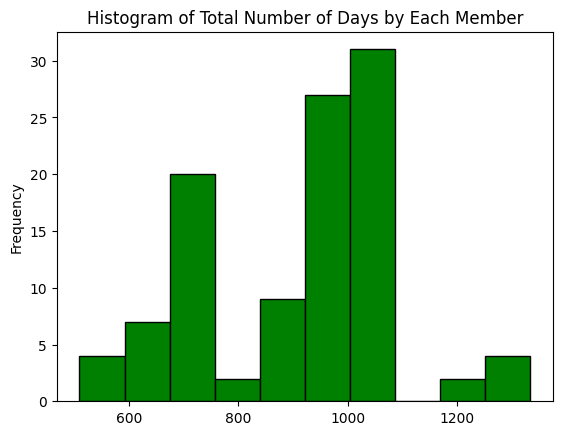

In [ ]:
plt.hist(order_duration['Total Number of Days'], color='green', edgecolor='black')
plt.ylabel('Frequency')
plt.title('Histogram of Total Number of Days by Each Member')
plt.show()

**Insights:**

- The 106 members have engaged with BigBasket for a duration ranging from 501 to 1,334 days.
- 50% of the members have used BigBasket for at least 957 days, reflecting long-term shopping behavior.
- The dataset provides robust insights into members' shopping patterns and trends over time.

### **Total different products placed by each member**

In [ ]:
products_by_member = data.groupby('Member').agg(products=('Description', 'nunique'))
products_by_member.sort_values(by='products', ascending=False).head()

,products
Member,
M43831,94
M36432,83
M54345,78
M41781,77
M25900,76


In [ ]:
products_by_member['products'].describe()

,products
count,106.000000
mean,56.216981
std,12.230333
min,26.000000
25%,49.000000
50%,55.500000
75%,63.750000
max,94.000000


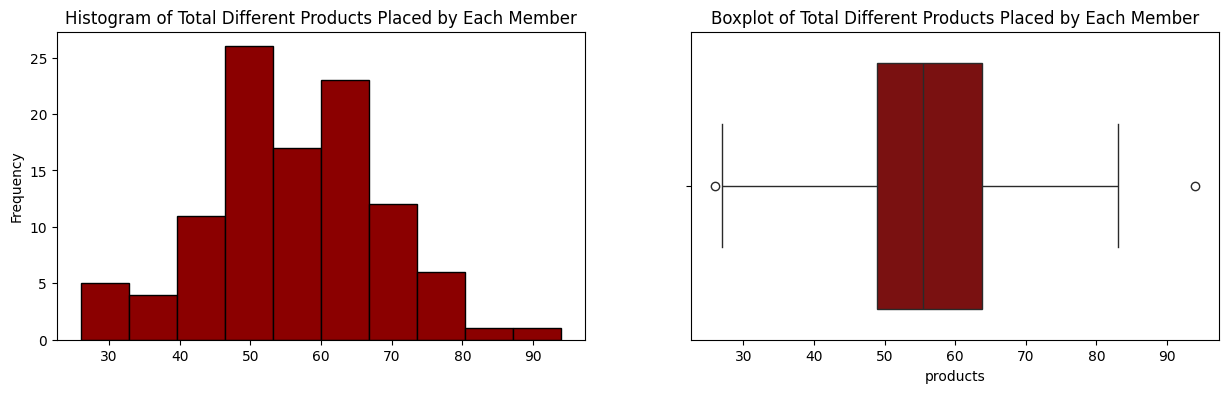

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

axes[0].hist(products_by_member['products'], color='darkred', edgecolor='black')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Total Different Products Placed by Each Member')

sns.boxplot(x=products_by_member['products'], ax=axes[1], color='darkred')
axes[1].set_title('Boxplot of Total Different Products Placed by Each Member')

plt.show()

**Insights:**

- Each member purchased between 26 and 94 different products, with an average of 56 products.
- The number of different products per member is concentrated around 50-60, indicating a common purchasing range.
- To develop an effective personalized recommendation system, a more precise pattern analysis is needed to avoid suggesting irrelevant products, given the wide variety of items purchased by each member.

### **Total products placed in each order**

In [ ]:
products_by_order = data.groupby('Order').agg(products_placed=('SKU', 'count'))
products_by_order.sort_values(by='products_placed').head()

,products_placed
Order,
7426408,1
8165667,1
7429339,1
7839459,1
6639858,1


In [ ]:
one_product_order = int(products_by_order[products_by_order['products_placed'] == 1].count())
print(f'There are {one_product_order} orders placing only 1 product.')
print(f'There are 8387 orders in total.')
print(f'{round(one_product_order / 8387 * 100, 2)}% orders placing only 1 product.')

There are 575 orders placing only 1 product.
There are 8387 orders in total.
6.86% orders placing only 1 product.


In [ ]:
less_than_five_product_order = int(products_by_order[products_by_order['products_placed'] < 5].count())
print(f'There are {less_than_five_product_order} orders placing fewer than five products.')
print(f'There are 8387 orders in total.')
print(f'{round(less_than_five_product_order / 8387 * 100, 2)}% orders placing fewer than five products.')

There are 2569 orders placing fewer than five products.
There are 8387 orders in total.
30.63% orders placing fewer than five products.


In [ ]:
products_by_order['products_placed'].describe()

,products_placed
count,8387.000000
mean,7.409205
std,4.960921
min,1.000000
25%,4.000000
50%,7.000000
75%,10.000000
max,42.000000


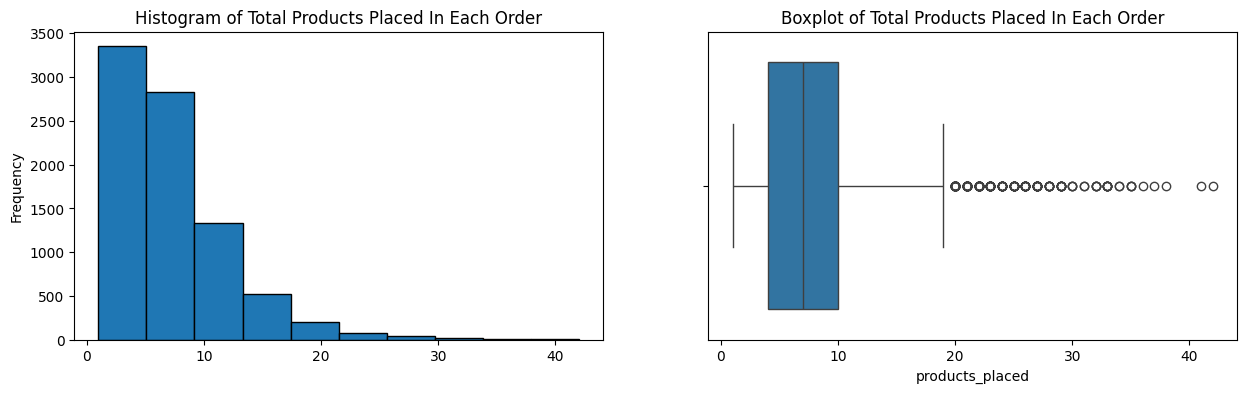

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

axes[0].hist(products_by_order['products_placed'], edgecolor='black')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Total Products Placed In Each Order')

sns.boxplot(x=products_by_order['products_placed'], ax=axes[1])
axes[1].set_title('Boxplot of Total Products Placed In Each Order')

plt.show()

**Insights:**

- 6.86% of orders contain only one product.
- 30.63% of orders include fewer than 5 products.
- 75% of orders consist of fewer than 10 products, while the largest order contains 42 products.
- Although an order can include up to 42 items, a significant portion consists of only a few products, suggesting that many orders might be placed to purchase forgotten items, aligning with concerns from the case study.
- This ordering inefficiency could lead to higher logistics and supply chain costs, highlighting the need for optimization strategies to encourage more consolidated purchases.

### **Product Type Popularity**

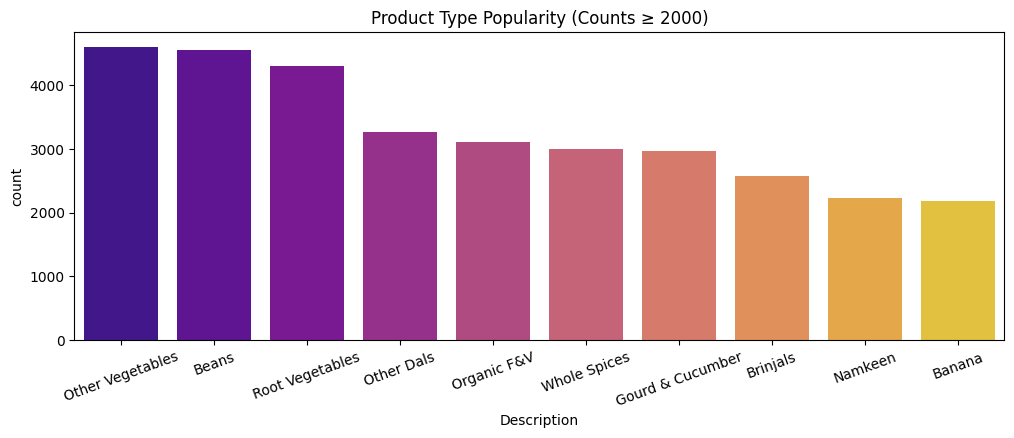

In [ ]:
plt.figure(figsize=(12, 4))
description_counts = data['Description'].value_counts()

# include product types that are at least purchased 1000 times
filtered_description = description_counts[description_counts >= 2000].index
filtered_data = data[data['Description'].isin(filtered_description)]

# Sort by count in descending order
sorted_descriptions = description_counts[filtered_description].sort_values(ascending=False).index

sns.countplot(data=filtered_data, x='Description', palette='plasma', order=sorted_descriptions)
plt.title('Product Type Popularity (Counts ≥ 2000)')
plt.xticks(rotation=20)
plt.show()

**Insights:**

- Among the 216 product types, the most frequently purchased items are vegetables, including beans, root vegetables, and other greens, with over 3,000 purchases made by 106 members.
- Other high-demand products, such as organic fruits and vegetables, whole spices, gourds & cucumbers, brinjals, namkeen, and bananas, have been purchased more than 2,000 times.
- BigBasket is primarily used for grocery shopping, with a strong focus on fresh produce, fruits, and spices.
- To maintain customer satisfaction, BigBasket should prioritize inventory management, ensuring these high-demand items remain readily available and fresh at all times.

### **Most frequent product type by each member**

In [ ]:
most_frequent_description = data.groupby('Member')['Description'].apply(lambda x: x.value_counts().idxmax())
most_frequent_description_count = data.groupby('Member')['Description'].apply(lambda x: x.value_counts().max())

description_by_member = pd.DataFrame({'Most Frequent Product': most_frequent_description,
                                      'Purchase Frequency': most_frequent_description_count})

description_by_member.sort_values(by='Purchase Frequency', ascending=False).head()

,Most Frequent Product,Purchase Frequency
Member,,
M38622,Organic F&V,435
M56368,Beans,222
M35538,Organic F&V,194
M52629,Namkeen,171
M31966,Other Vegetables,169


In [ ]:
description_by_member['Purchase Frequency'].describe()

,Purchase Frequency
count,106.000000
mean,84.471698
std,49.683227
min,24.000000
25%,54.000000
50%,75.000000
75%,101.000000
max,435.000000


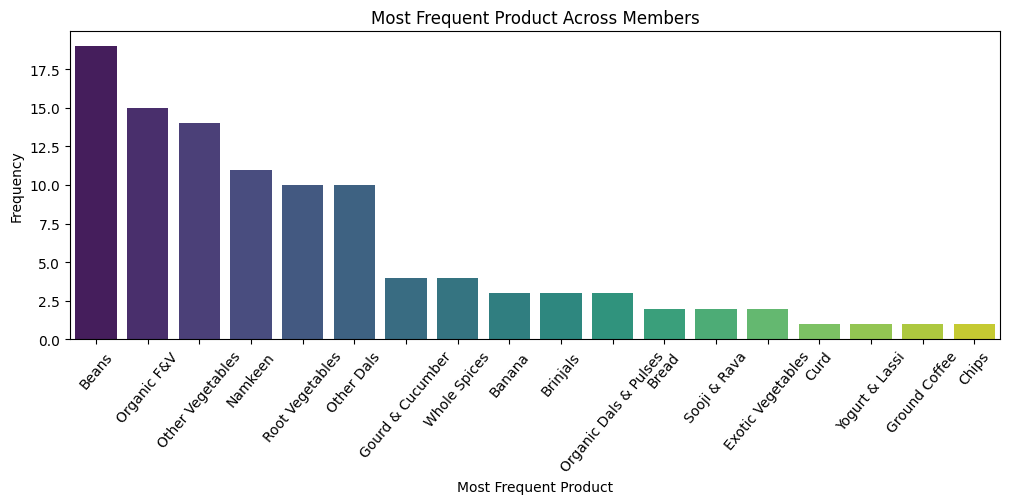

In [ ]:
plt.figure(figsize=(12, 4))
sns.barplot(x=description_by_member['Most Frequent Product'].value_counts().index,
            y=description_by_member['Most Frequent Product'].value_counts().values,
            palette='viridis')

plt.ylabel('Frequency')
plt.title('Most Frequent Product Across Members')
plt.xticks(rotation=50)
plt.show()

**Insights:**

- The most frequently purchased product types have been identified for each member.
- Organic fruits and vegetables were purchased 435 times by Member M38622, the highest for any single product type.
- For most members, their top-purchased items range between 50 and 100 times purchases, with a minimum of 24 times purchases, indicating consistent shopping patterns.
- The high frequency of repeated purchases across members suggests that shopping habits are predictable, making a personalized product recommendation system both feasible and valuable.
- Beans are the most frequently purchased product type among 18 members, followed by organic fruits and vegetables, highlighting key grocery preferences.

In [13]:
df = data.copy()

## **Part 3: Smart Basket - Apriori Algorithm**

Create a generic code to generate a smart basket of size m for a given member ID using the Apriori algorithm.

In [ ]:
# Helper Function
def prepare_data_Apriori(df, member):
  """
   Prepare data for Apriori Algorithm.
  """
  # each row records 1 order and corresponding products
  data = df[df['Member'] == member]
  data = data.groupby('Order')['Description'].agg(list).reset_index()

  # one-hot encoding: each column represents one product
  te = TransactionEncoder()
  te_ary = te.fit(data['Description'].tolist()).transform(data['Description'].tolist())

  df_encoded = pd.DataFrame(te_ary, columns=te.columns_, index=data['Order'])

  print('The data prepared for Apriori Algorithm:')
  print(df_encoded.head())
  print('==============================================================')
  return df_encoded

In [ ]:
# Helper Function
def filter_rules_by_basket_size(rules, basket_size):
  """
  Keep all rules with the specified basket size.
  """
  rules["basket_size"] = rules["antecedents"].apply(len) + rules["consequents"].apply(len)
  return rules[rules['basket_size'] == basket_size]

In [ ]:
# Helper Function
def best_basket(rules, criteria):
  """
  Generate smarket basket with the highest criteria value.
  """
  highest_rule = rules.sort_values(by=[criteria], ascending=False).iloc[0]
  basket = list(highest_rule['antecedents'].union(highest_rule['consequents']))
  return sorted(basket)

In [ ]:
# Main Function
def smart_basket(member, basket_size):
  """
  Generate a personalized shopping basket of a specified size for a given member.
  """

  # Prepare data for Apriori Algorithm
  df_encoded = prepare_data_Apriori(df, member)

  # Generate all possible product combinations
  # Support Pruning
  min_support = 0.05
  frequent_baskets = apriori(df_encoded, min_support=min_support, use_colnames=True)

  rules = association_rules(frequent_baskets)[['antecedents','consequents',
                                               'confidence', 'support', 'lift']]

  # Confidence pruning
  min_confidence = 0.2
  pruned_rules = rules[rules['confidence'] > min_confidence]

  # Lift Pruning
  min_lift = 1
  pruned_rules = pruned_rules[pruned_rules['lift'] > min_lift]

  # Keep all rules with the specified basket size
  basket_size_rules = filter_rules_by_basket_size(pruned_rules, basket_size)

  # Generate smarket basket with the highest support, confidence, or lift
  return (best_basket(basket_size_rules, 'support'),
          best_basket(basket_size_rules, 'confidence'),
          best_basket(basket_size_rules, 'lift'))

In [ ]:
# Example
print(f'The smart baskets for M36876 with size 5:')
print('==============================================================')
baskets_support, baskets_confidence, baskets_lift = smart_basket('M36876', 5)
print(f'Basket with highest support: {baskets_support}')
print(f'Basket with highest confidence: {baskets_confidence}')
print(f'Basket with highest lift: {baskets_lift}')

The smart baskets for M36876 with size 5:
The data prepared for Apriori Algorithm:
         Agarbatti  Avalakki / Poha  Banana  Beans  Besan  Boiled Rice  \
Order                                                                    
6640578      False            False   False   True  False        False   
6678297      False            False   False   True  False        False   
6686874      False            False   False  False  False        False   
6712708      False            False   False   True  False        False   
6808470      False            False    True   True  False        False   

         Brinjals  Cashews  Cookies   Ghee  ...  Raw Rice  Root Vegetables  \
Order                                       ...                              
6640578     False    False    False  False  ...     False             True   
6678297     False    False    False  False  ...     False            False   
6686874     False    False    False  False  ...     False             True   
6712708 

## **Part 4: Did You Forget? - Cosine Similarity Measure**
Develop a generic code to recommend a set of n missing products in a shopping basket for a given member ID using the Cosine similarity measure.  

In [9]:
# Helper Function
def prepare_data_similarity(df, member):
  """
  Prepare data for consine similarity measure.
  """

  data = df[df['Member'] == member][['Order', 'Description']]
  # Row index: Description; Columns: all orders; Entries: 0
  encoded_df = pd.DataFrame(0, index=data['Description'].unique(),
                            columns=data['Order'].unique())

  # For each description, count the occurrence in each order
  for _, row in data.iterrows():
    encoded_df.loc[row['Description'], row["Order"]] += 1

  # Normalize by row (each description) so that the sum of each row is 1
  encoded_df = encoded_df.div(encoded_df.sum(axis=1), axis=0)


  print('The data prepared for Cosine Similarity:')
  print(encoded_df.head(2))
  print('==============================================================')
  return encoded_df

In [10]:
# Helper Function
def compute_similarity_matrix(df, member):
  """
  Compute Product by Product Similarity Matrix.
  """

  cosine_matrix = cosine_similarity(df)
  product_similarity_df = pd.DataFrame(cosine_matrix, index=df.index, columns=df.index)
  print('The product by product similarity matrix:')
  print(product_similarity_df.head(2))
  print('==============================================================')

  return product_similarity_df

In [11]:
# Main function
def recommend_missing_products(member, n):

  # Prepare data for consine similarity measure
  encoded_df = prepare_data_similarity(df, member)

  # Product by product consine similarity matrix
  product_similarity_df = compute_similarity_matrix(encoded_df, member)

  # Create a dictionary of top-n similar products for each product
  # Key: product
  # Value: List of tuples (similar products, similarity score)
  output = {}
  for product in product_similarity_df.index:
    similars = product_similarity_df.loc[product].drop(product).sort_values(ascending=False).head(n)
    output[product] = [(sim, round(float(score), 4)) for sim, score in
                       zip(similars.index, similars.values)]

  print(f"A dictionary for top {n} similar products for each product is generated.")

  # Preview first two products
  print(f"\nPreview of the output:")
  for product, similar_list in islice(output.items(), 3):
    print(f"\n{product} - Top {n} Similar Products:")
    for sim, score in similar_list:
        print(f"  → Similar Product: {sim}, Score: {score}")

  return output

In [14]:
# Example recommendation of n missing products
print(f'The recommended missing 3 products for M32409 are:')
print('==============================================================')
output = recommend_missing_products('M32409', 3)

The recommended missing 3 products for M32409 are:
The data prepared for Cosine Similarity:
                   6439325   6439360   6457975   6481313   6500391   6532863  \
Other Vegetables  0.019417  0.000000  0.009709  0.019417  0.019417  0.019417   
Cream Biscuits    0.019608  0.009804  0.019608  0.019608  0.019608  0.000000   

                   6571342  6572551  6572650   6613908  ...   8289882  \
Other Vegetables  0.019417      0.0      0.0  0.019417  ...  0.019417   
Cream Biscuits    0.019608      0.0      0.0  0.019608  ...  0.000000   

                   8294783  8296093   8309883   8319194   8328263   8342751  \
Other Vegetables  0.019417      0.0  0.009709  0.009709  0.019417  0.009709   
Cream Biscuits    0.029412      0.0  0.019608  0.000000  0.019608  0.019608   

                   8361465   8373771   8381842  
Other Vegetables  0.019417  0.009709  0.009709  
Cream Biscuits    0.029412  0.019608  0.019608  

[2 rows x 73 columns]
The product by product similarity matri